# CMPT 743 - GAN Mode Collapse Assignment

## Objective
Understand how hyperparameter settings affect GAN training by implementing and comparing two scenarios:
- Settings that cause **mode collapse**
- Settings that enable **stable training**

## What is Mode Collapse?
Mode collapse occurs when the generator learns to produce only a small subset of possible outputs. For example, instead of generating all digits 0-9, it might only generate 1 or 2 different digits repeatedly.

## Your Tasks
1. Implement a GAN trainer with configurable hyperparameters
2. Run training with two different configurations
3. Compare and analyze the results

In [1]:
#@title import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image

from tqdm import tqdm

import os

In [2]:
#@title load dataset

batch_size = 100
#TODO: define transform that turns images to torch tensors and normalizes them to (-1, 1)
#Hint: use transforms.ToTensor() and transforms.Normalize()
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


trainloader = DataLoader(mnist_trainset, batch_size = batch_size, num_workers = 0, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

for i in range(100):
    image, label = mnist_trainset.__getitem__(i)

    if label == 2:
        plt.figure(figsize=(2, 2))
        plt.imshow(image.squeeze(0), cmap='gray')  # Remove channel dim and plot in grayscale
        plt.axis("off")
        plt.title(f"Label: {label}")
        plt.show()

In [4]:
#@title Define generator model
class Generator(nn.Module):
  def __init__(self, noise_dim, out_dim):
    super(Generator, self).__init__()
    #noise_dim: dimension of input noise vector
    #out_dim: dimenstion of output image in our case 28 * 28

    #TODO: define fully connected network with dims: noise_dim -> 256 -> 512 -> 512 -> out_dim
    self.fc1 = nn.Linear(noise_dim, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 512)
    self.fc4 = nn.Linear(512, out_dim)

  def forward(self, x):
    out = F.relu(self.fc1(x))
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))
    out = torch.tanh(self.fc4(out))

    return out


In [5]:
G = Generator(100, 28 * 28)
print(G)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)


In [6]:
#@title Define discriminator model
class Discriminator(nn.Module):
  def __init__(self, image_dim):
    super(Discriminator, self).__init__()
    #image_dim: dimension of input image. in our case 28 * 28
    #TODO define linear layers with dims image_dim -> 256 -> 128 -> 64 -> 1
    self.fc1 = nn.Linear(image_dim, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 1)


  def forward(self, x):
     out = F.leaky_relu(self.fc1(x), negative_slope = 0.2)
     out = F.dropout(out, p=0.3)
     out = F.leaky_relu(self.fc2(out), negative_slope = 0.2)
     out = F.dropout(out, p=0.3)
     out = F.leaky_relu(self.fc3(out), negative_slope = 0.2)
     out = F.dropout(out, p=0.3)
     out = torch.sigmoid(self.fc4(out))
     return out

In [7]:
D = Discriminator(28 * 28)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


# GAN Trainer Implementation

Create a unified GAN trainer that can run with different configurations to demonstrate:
1. **Mode Collapse** - when settings cause the generator to produce limited varieties
2. **Stable Training** - when settings allow diverse, high-quality outputs

---

## Part 1: Understanding the Trainer Parameters

The `GANTrainer` class takes several parameters that control training:

### Key Parameters:
- **`g_lr`**: Learning rate for the generator
  - Controls how fast G learns
  
- **`d_lr`**: Learning rate for the discriminator  
  - Controls how fast D learns
  
- **`d_updates_per_g`**: How many times D is updated before updating G once
  - Value of 1 means balanced training (update D and G equally)
  - Higher values make D train more than G

### Why These Matter:
If D becomes too strong (learns too fast or trains too much), it can perfectly distinguish real from fake. When this happens, G receives no useful gradient and cannot improve, leading to mode collapse.

---

In [9]:
#@title Unified GAN Trainer

noise_dim = 100

class GANTrainer:
  def __init__(self, g_lr, d_lr, d_updates_per_g, fig_dir, checkpoint_dir, eval_freq=5):
    """
    Unified GAN Trainer with configurable hyperparameters.
    
    Args:
        g_lr: Generator learning rate
        d_lr: Discriminator learning rate
        d_updates_per_g: Number of discriminator updates per generator update
        fig_dir: Directory to save generated images
        checkpoint_dir: Directory to save model checkpoints
        eval_freq: Evaluate and save every N epochs
    """
    self.G = Generator(noise_dim = noise_dim, out_dim = 28 * 28).to('cuda:0')
    self.D = Discriminator(image_dim = 28 * 28).to('cuda:0')

    # TODO: Initialize optimizers with the provided learning rates
    # Hint: Use torch.optim.Adam() with g_lr for G and d_lr for D
    
    
    # TODO: Store the D update ratio

    self.criterion = nn.BCELoss()
    self.eval_freq = eval_freq
    self.fig_dir = fig_dir
    self.checkpoints_dir = checkpoint_dir

    os.makedirs(self.fig_dir, exist_ok = True)
    os.makedirs(self.checkpoints_dir, exist_ok = True)

  def run(self, epochs=50):
    for e in range(1, epochs + 1):
      self.train_step(e)
      if e % self.eval_freq == 0:
        self.eval_step(e)
        self.save_step(e)

  def train_step(self, epoch):
      self.G.train()
      self.D.train()
      pbar = tqdm(trainloader)
      for i, data in enumerate(pbar):
        real_data, _ = data
        real_data = real_data.cuda()
        real_data = real_data.view(batch_size, -1)

        # TODO: Implement training loop with configurable D:G update ratio
        # Train D self.d_updates_per_g times, then train G once
        # Hint: Use a for loop with self.d_updates_per_g iterations for D
        D_loss = 0
        for _ in range(self.d_updates_per_g):
          pass
        
        


        pbar.set_description(f"Epoch: {epoch}, G_loss = {G_loss:.4f}, D_loss = {D_loss:.4f}")

  def train_D(self, real_data):
      # TODO: Train discriminator
      # 1. Feed real data to D and compute loss with label=1
      # 2. Generate fake data from G and feed to D, compute loss with label=0
      # 3. Combine losses and backpropagate
      self.D_optimizer.zero_grad()
    
      
      pass

  def train_G(self):
      # TODO: Train generator
      # 1. Generate fake data from random noise
      # 2. Feed to D and compute loss with label=1 (we want D to think it's real)
      # 3. Backpropagate
      self.G_optimizer.zero_grad()

      latent = torch.randn(batch_size, noise_dim).cuda()
      
      pass

  def eval_step(self, epoch):
      self.G.eval()
      with torch.no_grad():
        noise = torch.randn((16, noise_dim)).cuda()
        images = self.G(noise).view(-1, 28, 28)
        images = images.clamp(-1, 1).cpu().numpy()
        images = ((images + 1) * 127.5).astype('uint8')
      
      # Create 4x4 grid
      grid = np.zeros((4*28, 4*28), dtype='uint8')
      for idx in range(16):
        i, j = idx // 4, idx % 4
        grid[i*28:(i+1)*28, j*28:(j+1)*28] = images[idx]
      
      Image.fromarray(grid).save(os.path.join(self.fig_dir, f'fig_{epoch}.png'))

  def save_step(self, epoch):
      torch.save(self.G.state_dict(), os.path.join(self.checkpoints_dir, f'gen_weights_{epoch}.pth'))

---

## Part 2: Implementation TODOs

Complete the following sections in the `GANTrainer` class:

### TODO 1: Initialize Optimizers
Create Adam optimizers for both G and D using the provided learning rates.

### TODO 2: Training Loop  
Update D multiple times (based on `d_updates_per_g`), then update G once.

### TODO 3: Train Discriminator
Train D to classify real images as real (label=1) and fake images as fake (label=0).

### TODO 4: Train Generator
Train G to generate images that fool D (make D output label=1).

---

# Experiment 1: Mode Collapse Settings

Configure the trainer with **imbalanced** settings that cause mode collapse.

---

## Part 3: Experiments

You will run two experiments to see the impact of different hyperparameters.

### Experiment 1: Mode Collapse
Use settings that make D too strong:
- Very low G learning rate (0.00005)
- High D learning rate (0.001) - 20x higher!
- Train D 5 times per G update

**Expected result**: Generator produces only 1-2 digit types repeatedly

### Experiment 2: Stable Training  
Use balanced settings:
- Equal learning rates (0.0002 for both)
- Train D and G equally (1:1 ratio)

**Expected result**: Generator produces diverse digits (0-9)

---

In [ ]:
# TODO: Configure mode collapse settings
# Hint: Use very low G learning rate, high D learning rate, and multiple D updates per G
# Recommended: g_lr=0.00005, d_lr=0.001, d_updates_per_g=5



Epoch: 1, G_loss = 14.8391, D_loss = 0.0008: 100%|██████████| 600/600 [00:16<00:00, 37.05it/s]


# Experiment 2: Stable Training Settings

Configure the trainer with **balanced** settings that prevent mode collapse.

In [ ]:
# TODO: Configure stable training settings
# Hint: Use equal learning rates for G and D, and 1:1 update ratio
# Recommended: g_lr=0.0002, d_lr=0.0002, d_updates_per_g=1



Epoch: 1, G_loss = 0.9594, D_loss = 1.3087: 100%|██████████| 600/600 [00:10<00:00, 55.62it/s]


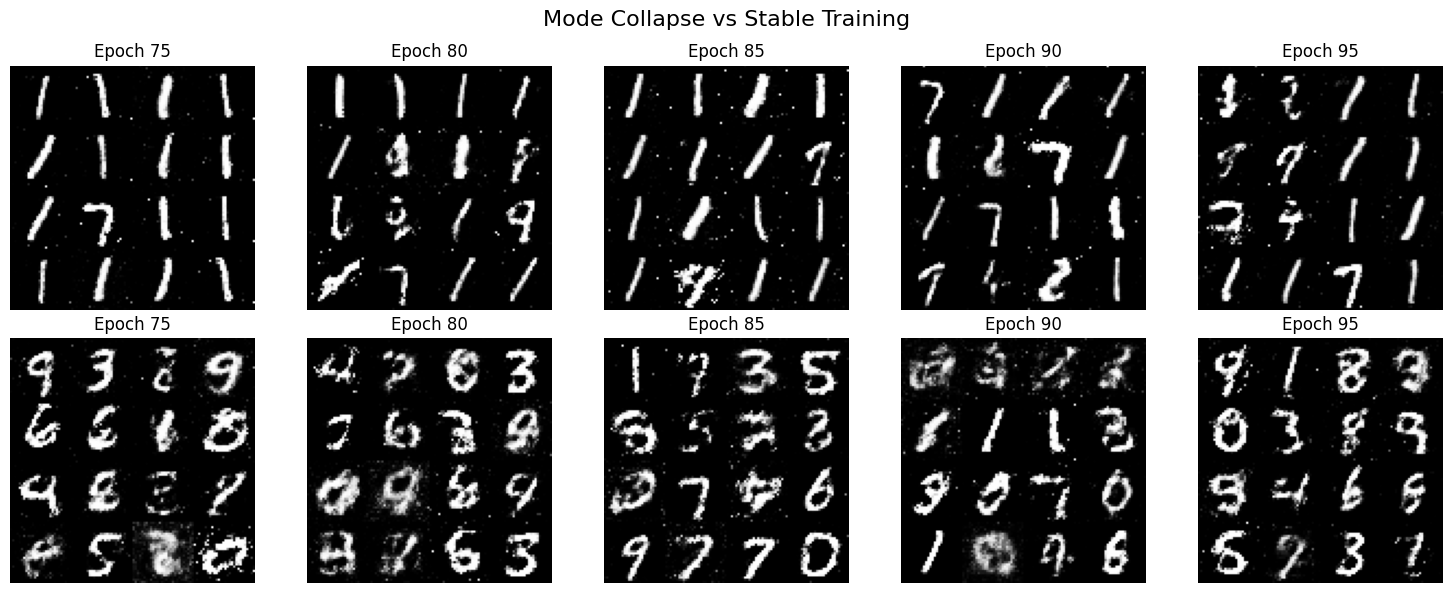

Saved comparison to comparison.png


In [34]:
#@title Visualize and Compare Results

import matplotlib.pyplot as plt
from glob import glob

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Mode Collapse vs Stable Training', fontsize=16)

# Mode collapse images
collapse_images = sorted(glob('./figs_collapse/fig_*.png'))
if len(collapse_images) >= 5:
    for i, img_path in enumerate(collapse_images[-5:]):
        img = Image.open(img_path)
        epoch_num = img_path.split('_')[-1].split('.')[0]
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Epoch {epoch_num}')
        axes[0, i].axis('off')

# Stable training images
stable_images = sorted(glob('./figs_stable/fig_*.png'))
if len(stable_images) >= 5:
    for i, img_path in enumerate(stable_images[-5:]):
        img = Image.open(img_path)
        epoch_num = img_path.split('_')[-1].split('.')[0]
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Epoch {epoch_num}')
        axes[1, i].axis('off')

axes[0, 0].set_ylabel('Mode Collapse', fontsize=14)
axes[1, 0].set_ylabel('Stable Training', fontsize=14)

plt.tight_layout()
plt.savefig('comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved comparison to comparison.png')

---

## Part 4: Analysis

After running both experiments, compare the results:

### What to Look For:
- **Mode Collapse**: Do you see the same digit(s) repeated in the grid? This means the generator has collapsed to producing only a few modes.
  
- **Stable Training**: Do you see variety in the generated digits? All 10 digits should appear with good quality.

### Questions to Consider:
1. Why does a stronger discriminator cause mode collapse?
2. What happens to the generator's gradient when D is too good?
3. How does the D:G update ratio affect training balance?

---